# Notes for xarrayutils.composite
There should be an option to resample the timeseries according to the data...or at least a warning if not all time steps are found in data...otherwise you end up with an empty array

In [1]:
import numpy as np
import xarray as xr
import xarray.ufuncs as xu
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates  as mdates
from mpl_toolkits.basemap import Basemap
import xarrayutils as xut
from xarrayutils import aggregate
from dask.array import from_array

%matplotlib inline
mpl.rc('font', family='sans-serif')
mpl.rc('font', serif='Helvetica') 
# mpl.rc('font', family='serif') 
# mpl.rc('font', serif='Times New Roman') 
# plt.style.use('ggplot')
mpl.rc('text', usetex=False) 
mpl.rcParams.update({'font.size': 20})
plt.rcParams.update({'mathtext.default':  'regular' })
from dask.diagnostics import ProgressBar
%matplotlib inline

def geom_mean(da, dim=None, axis=None):
    if dim is not None:
        if axis is not None:
            raise ValueError('cannot set both `dim` and `axis`')
        if isinstance(da, xr.Dataset):
            axis = da[da.data_vars.keys()[0]].get_axis_num(dim)
        elif isinstance(da, xr.DataArray):
            axis = da.get_axis_num(dim)
#     if isinstance(da,xr.DataArray)
    
    if isinstance(da,np.ndarray):
        da[da<=0] = np.nan
        a = np.log(da)
        out = np.exp(np.nanmean(a,axis=axis))
    elif isinstance(da,(xr.DataArray,xr.Dataset)):
        da = da.where(da > 0)
        a = xr.ufuncs.log(da)
        out = xr.ufuncs.exp(a.mean(dim))
    else:
        raise RuntimeError('data type of da not supported')
    return out

def harm_mean(da, dim=None, axis=None):
    if dim is not None:
        if axis is not None:
            raise ValueError('cannot set both `dim` and `axis`')
        if isinstance(da, xr.Dataset):
            axis = da[da.data_vars.keys()[0]].get_axis_num(dim)
        elif isinstance(da, xr.DataArray):
            axis = da.get_axis_num(dim)
    if isinstance(da,np.ndarray):
        da[~xr.ufuncs.isfinite(da)] = np.nan
        da[abs(da) == 0.0] = np.nan
        a = 1.0/da
        out = 1.0/(np.nanmean(a,axis=axis))
    elif isinstance(da,(xr.DataArray,xr.Dataset)):
        da = da.where(xr.ufuncs.isfinite(da))
        da = da.where(da != 0.0)
        a = 1.0/da
        out = 1.0/(a.mean(dim))
    else:
        raise RuntimeError('data type of da not supported')
    return out

def xarray_norm(in_a, norm_a):
    out_norm = ((in_a - np.nanmean(in_a.data)) / np.nanstd(in_a.data) *
                np.nanstd(norm_a)) + np.nanmedian(norm_a)
    return out_norm


def xarray_removeSeasonal(da, groupspec='time.month', func=harm_mean):
    print('choose the mean function appropriate!!!')
    mean = func(da, 'time')
    season_removed = da.groupby(groupspec).apply(
        lambda x: x - func(x, 'time'), shortcut=False) + mean
    return season_removed.drop(groupspec[5:])


def RMSE(da, error_dim, mean_dim='time', max_dim=None, func='mean'):
    print('which mean ?')
    mean = da.mean(dim=error_dim)
    an = da - mean
    if max_dim:
        an = an.max(max_dim)
    an_sq = xr.ufuncs.sqrt(an)
    
    if func == 'geo_mean':
        # this doesnt work with dask arrays...
        mse = geom_mean(an_sq, mean_dim)
    elif func == 'harm_mean':
        # this doesnt work with dask arrays...
        mse = harm_mean(an_sq, mean_dim)
    elif func == 'mean':
        mse = an_sq.mean(dim=mean_dim)
    else:
        raise RuntimeError('func parameter not recognized')
        
    out = xr.ufuncs.sqrt(mse)
    return mse


def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z


def combine_Kmin(ds,ds_target,func=harm_mean):
    """Combines data array according to the min time/tracernum mean value of ds_target"""
    # Error estimate
    # Should I consider a time resolved version for the final product?
    ds_target = func(ds_target,['tracernum','time'])
    mask = ds_target == ds_target.min('initial_condition')
    out = func(ds.where(mask), ['initial_condition','tracernum'])
    return out


def replace_dim(da, olddim, newdim):
    renamed = da.rename({olddim: newdim.name})
    # note that alignment along a dimension is skipped when you are overriding
    # the relevant coordinate values
    renamed.coords[newdim.name] = newdim
    return renamed

# def range_check(da,q,inf_replace=True):
#     if isinstance(q,(list,np.ndarray)):
#         low = q[0]
#         up = q[1]
#     elif isinstance(q,float):
#         low = da.quantile(q).data
#         up = da.quantile(1-q).data
        
#     print 'lower bound', low
#     print 'upper bound', up
#     da.data[da.data<low] = low
#     da.data[da.data>up] = up
#     if inf_replace:
#         da.data[xr.ufuncs.isinf(da.data)] = up
    
#     return da

# def smooth_da(da,months=3):
# #     return xut.timefilter(da,30*months,'D',stdev=0.15)
#     return da.rolling(time=months,center=True).reduce(harm_mean)

def apply_QC(ds, crit_cut=1, mask_perc=1.0):
    """Apply all QC steps to ds_qc
    """
    with ProgressBar():
        ds = ds.compute()
    
    # Gross range check (the harmonic mean is incredible sensitive to the small values)
    # eliminate the 1st and 99th percentile
    print('### KOC range check ###')
#     ds['KOC'] = range_check(ds.KOC,[10.0,1e5])
    ds['KOC'] = range_check(ds.KOC,0.01)
    print('### criterion range check ###')
    ds['gradient_criterion'] = range_check(ds.gradient_criterion,0.01)
    
    # Time valid index
    ds_qc = ds.where(ds.valid_index==1)

    # Landmask
    max_count = ds_qc.mask_count.max()
    ds_qc = ds_qc.where(ds_qc.mask_count>=(mask_perc*max_count))

    # Valid criterion | Remove values where l_curv<=l_mix
    crit_raw = ds_qc['gradient_criterion']
    crit_raw = crit_raw.where(xu.isfinite(crit_raw))
    crit = geom_mean(crit_raw,'time')
    
    if (crit_raw < 0).any():
        raise RuntimeError('The gradient criterion should not have negative values')

    if xu.isinf(crit_raw).any():
        raise RuntimeError('The gradient criterion should not have inf values')
        
    if xu.isinf(ds_qc.KOC).any():
        raise RuntimeError('KOC should not have inf values')

    ds_qc = ds_qc.where(crit<=crit_cut)
    
    #Error Estimate for each initial condition
    ds_qc['KOC_Error_tracer'] = RMSE(ds_qc.KOC,'tracernum','time',func='harm_mean').max('tracernum')
    
    return ds_qc 

In [2]:
# Global Parameters

# Read and process KOC data
ddir = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/Data_Kmin/raw'
odir = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/Data_Kmin'
pdir = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/PLOTS/Analysis_KOCpaper'

Boxes = {'South Pacific':np.array([210,280,-45,-15]),
         'North Pacific':np.array([170,225,15,45]),
         'South Atlantic':np.array([310,359,-45,-15]),
         'North Atlantic':np.array([300,340,15,45]),
         'SPURS1':np.array([315,330,15,30]),
         'SPURS2':np.array([120,135,5,15])
         }

# weights = 'area'
# !!! I need to write a function that calculates area from lat lon
# weights=None
# timespec = 'month' #For the seasonal averages

# Custom plot styles
init_dict = dict(x='lon',y='lat',col='initial_condition',col_wrap=2,size=3,aspect=1.8)
crit_style = dict(vmin=0,vmax=2,cmap=plt.cm.RdBu_r)
ratio_style = dict(vmin=0,vmax=10,cmap=plt.cm.Reds)
koc_style = dict(vmin=1e2,vmax=3e3,norm=mpl.colors.SymLogNorm(10))

koc_an_style = dict(vmin=0, vmax=koc_style['vmax'],
                    cmap=plt.cm.RdBu_r, norm=mpl.colors.SymLogNorm(10))

rmse_style = koc_style.copy();
rmse_style['vmax'] = 1e2
# # For the mapping (currently not used)
# lon0=180
# proj = ccrs.Mercator(lon0)
# init_map_dict = dict(transform=ccrs.PlateCarree(),subplot_kws=dict(projection=proj))

# Calculate the Kmin composite
- Why are there still these outliers? Minor problem atm

In [ ]:
# %%time
inits = ['LAT','PSI','SSS','SST']
KOC_raw = xr.concat([xr.open_dataset(ddir+'/KOC_'+f+'_FINAL.nc',chunks={'time':1}) for f in inits],
                    xr.DataArray(inits,dims=['initial_condition'],name='initial_condition'))

# Replace dims with lat lon (should I remove the XC etc?)
lon = xr.DataArray(KOC_raw.XC.isel(j=0).data,dims=['lon'],name='lon')
lat = xr.DataArray(KOC_raw.YC.isel(i=0).data,dims=['lat'],name='lat')
KOC_raw = replace_dim(KOC_raw,'i',lon)
KOC_raw = replace_dim(KOC_raw,'j',lat)

print('### Applying QC ###')

# KOC_raw = KOC_raw.compute()
KOC = apply_QC(KOC_raw,crit_cut=1)

print('### Writing raw data ###')
with ProgressBar():
    KOC_raw.to_netcdf(odir+'/KOC_raw.nc')

print('### Writing raw quality controlled data ###')
KOC.to_netcdf(odir+'/KOC.nc')

# Calculate Mixing Length
KOC['MixingLength'] = KOC.RMSTracer/KOC.GradTracer/1000.0
KOC['MixingLength'].attrs['units'] = 'km'

##  Combine into Kmin
Kmin = combine_Kmin(KOC.KOC,KOC.KOC)
Kmin['MixingLength'] = combine_Kmin(KOC.MixingLength,KOC.KOC,func=xr.DataArray.mean)
Kmin['Error'] = RMSE(KOC.KOC,['initial_condition','tracernum'],mean_dim=['tracernum','time','initial_condition'])

print('### Writing Kmin ###')
with ProgressBar():
    Kmin.to_netcdf(odir+'/Kmin.nc')

In [ ]:
# Quick check if the 2 deg results look ok
Kmin.mean('time').plot(x='lon',y='lat',robust=True)

In [ ]:
# # This should be integrated into xarrayutils... I thought I have something like that already...
# # Convert lon convention

# ## for now do it quick and dirty
# def convertLon(ds,lon_name='lon',source_convention='180'):
#     """Shifts and converts xarray.dataset/array into opposing longitude convention
#     Right now it only works with lat lon dimensions, not with 2d coordinates """
#     # compute the content if lon data is 
    
#     if source_convention == '180':
        
#         ds[lon_name].data[ds[lon_name].data<0] = 360.0 + ds[lon_name].data[ds[lon_name].data<0]
#     elif source_convention == '360':
#         ds[lon_name].data[ds[lon_name].data>180] = ds[lon_name].data[ds[lon_name].data>180]- 360.0
#     else:
#         raise RuntimeError('source convention not recognized. Choose between "180" and "360"')
#     return ds

In [ ]:
temp.data_vars.keys()

# Main Routine


In [4]:
# Reload all data
Kmin = xr.open_dataset(odir+'/Kmin.nc',chunks={'time':1})
KOC = xr.open_dataset(odir+'/KOC.nc',chunks={'time':1})
KOC_raw = xr.open_dataset(odir+'/KOC_raw.nc',chunks={'time':1})

# Read Ryans EKE
eke_file_high_res = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/From_Ryan/eke_monthly_mean_stddev6.nc'
eke_file          = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/From_Ryan/eke_monthly_mean_coarse_stddev6.nc'

# This should go away when ryan reprocesses the files
patch_time = xr.open_dataset(eke_file_high_res).time

### This processing should be overhauled and done before this code
# Read Monthly aviso
# aviso_file = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/From_Ryan/large_scale_monthly_mean_stddev6.nc'
aviso_file = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/From_Ryan/large_scale_monthly_mean_coarse_stddev6.nc'
VEL = xr.open_dataset(aviso_file,chunks={'time':1})
#!!!# # Patch in the mean velocity
path = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/AVISO_mean/time_mean.nc'
temp = xr.open_dataset(path,chunks={'time':1}).drop(['nv','lat_bnds','lon_bnds','crs']).mean('time')
MDT = xr.Dataset()
for vv in temp.data_vars.keys():
    MDT[vv] = aggregate(temp[vv],[('lon',8),('lat',8)])

VEL['time'] = patch_time
VEL = VEL.reindex_like(Kmin.KOC, method='nearest')+MDT.reindex_like(Kmin.KOC, method='nearest')



EKE = xr.open_dataset(eke_file,chunks={'time':1}).rename({'__xarray_dataarray_variable__':'eke'}).load()
EKE['time'] = patch_time
EKE['eke_noSeasonal'] = xarray_removeSeasonal(EKE.eke)
EKE = EKE.reindex_like(Kmin.KOC, method='nearest')

# # Climate Indicies
# ddir_indicies = '/Users/juliusbusecke/Work/DATA_OLD/CLIM_IND/OUTPUT'
# fid_indicies = ['AMO','PDO','ENSO','NAO','SOI','DMI']
# climate_indicies = xr.merge(\
#         [xr.open_dataset(ddir_indicies+'/'+a+'.nc').reindex_like(Kmin.KOC,method='nearest') for a in fid_indicies])

# AGVA
path = '/Users/juliusbusecke/Work/DATA/AGVA/OUTPUT/AGVA_v1.2_vel_combined2004-2010.nc'
AGVA = xr.open_dataset(path,chunks={'time':1}).drop(['geostrophic_streamfunction',
                                                   'seasonal_stddev_zonal_velocity',
                                                   'seasonal_stddev_meridional_velocity',
                                                   'monthly_stddev_zonal_velocity',
                                                   'monthly_stddev_meridional_velocity'])

# convert to barotropic (depth averaged) flow
AGVA = AGVA.mean('pressure').rename({'longitude':'lon','latitude':'lat','time':'t'})

# Coarsen to 2 deg bins
AGVA_coarse=xr.Dataset()
for kk in AGVA.data_vars:
    AGVA_coarse[kk] = aggregate(AGVA[kk],[('lon',2),('lat',2)]).reindex_like(Kmin.KOC,method='nearest')
AGVA = AGVA_coarse.rename({'t':'time'})

### Load the ECCO data ###
path = '/Users/juliusbusecke/Work/DATA/ECCO/Temp/ECCO_barotropic_vel.nc'
ECCO = xr.open_dataset(path,chunks={'time':1})
# Quick and dirty shift of the coordinates (!!! This should be generalized!!! ==> xarrayutils)
temp = ECCO.lon.data.compute()
temp[temp<0] = 360.0 + temp[temp<0]
shift_i = 360
temp = np.roll(temp,shift_i)
ECCO.lon.data = from_array(temp,temp.shape)
ECCO = xr.concat([ECCO.shift(i4=360),ECCO.shift(i4=-360)],dim='shift').mean('shift')
ECCO['i4'].data = ECCO.lon.isel(i3=0).data
ECCO['i3'].data = ECCO.lat.isel(i4=0).data
ECCO = ECCO.drop(['lon','lat']).rename({'i3':'lat','i4':'lon'})

# Coarsen to 2 deg bins
ECCO = ECCO.rename({'time':'t'})
ECCO_coarse=xr.Dataset()
for kk in ECCO.data_vars:
    ECCO_coarse[kk] = aggregate(ECCO[kk],[('lon',4),('lat',4)]).reindex_like(Kmin.KOC,method='nearest')
ECCO = ECCO_coarse.rename({'t':'time'})

###

# now do all the datasets
# EKE['eke_smooth'] = smooth_da(EKE['eke'])
# KOC_merged = harm_mean(KOC,'tracernum')
# for vv in ['KOC','Numerator','Denominator']:
#     KOC_merged[vv] = smooth_da(KOC_merged[vv])

# !!!I should probably implement this right after the QC and before the merging
time_smooth = 3
Kmin['KOC_raw'] = Kmin['KOC']
Kmin['KOC'] = smooth_da(Kmin['KOC'],months=time_smooth)

choose the mean function appropriate!!!


/Users/juliusbusecke/anaconda2/envs/standard/lib/python2.7/site-packages/dask/array/core.py:2740: RuntimeWarning: Mean of empty slice
  dt = reduction(np.empty((1,) * x.ndim, dtype=x.dtype)).dtype
/Users/juliusbusecke/anaconda2/envs/standard/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


/Users/juliusbusecke/anaconda2/envs/standard/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


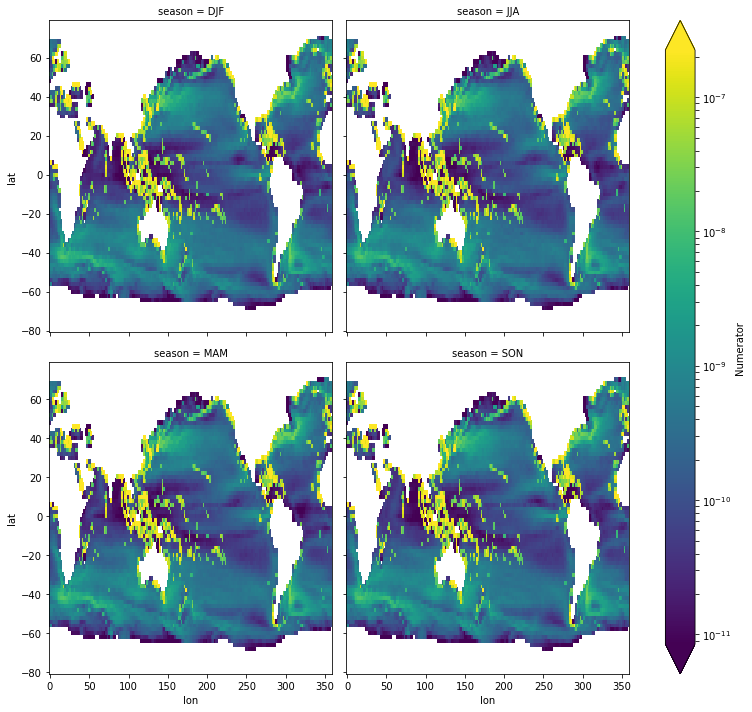

In [48]:
# Make seasonal plots (now for sjoerd, but this could be another paper)


raw =  KOC_raw.Numerator.sel(initial_condition='SST').reduce(harm_mean,dim=['tracernum'])
# raw =  Kmin.KOC

data =raw.groupby('time.season').reduce(harm_mean,dim=['time'])
data_mean = raw.reduce(harm_mean, dim=['time'])


# (data-data_mean).plot(x='lon',y='lat',col='season',col_wrap=2,
#                       norm=mpl.colors.SymLogNorm(300),
#                       vmin=-1e3,vmax=1e3,
#                       cmap=plt.cm.RdBu_r,size=5,aspect=1)

# (data).plot(x='lon',y='lat',col='season',col_wrap=2,
#                       norm=mpl.colors.LogNorm(),
#                       vmin=1e2,vmax=5e3,
#                       size=5,aspect=1)

(data).plot(x='lon',y='lat',col='season',col_wrap=2,
                      norm=mpl.colors.LogNorm(),
                      robust=True,
                      size=5,aspect=1)


# KOC_raw.KOC.sel(initial_condition='SST').groupby('time.season').reduce(harm_mean,
#                                                                        dim=['time','tracernum']).plot(x='lon',
#                                                                                                       y='lat',
#                                                                                                       col='season',
#                                                                                                       col_wrap=2,
#                                                                                                       norm=mpl.colors.LogNorm(),
#                                                                                                       vmin=1e2,
#                                                                                                       vmax=1e4)


In [ ]:
# #!!!# smooth the vel stuff as well...
# time_smooth = 5
# ECCO['NVELMASS'] = smooth_da(ECCO['NVELMASS'],months=time_smooth,func=np.nanmean)
# ECCO['EVELMASS'] = smooth_da(ECCO['EVELMASS'],months=time_smooth,func=np.nanmean)

# AGVA['zonal_velocity'] = smooth_da(AGVA['zonal_velocity'],months=time_smooth,func=np.nanmean)
# AGVA['meridional_velocity'] = smooth_da(AGVA['meridional_velocity'],months=time_smooth,func=np.nanmean)

# for tomorrow

- Try to calculate the ANOMALIES of the AGVA instead of the total!
(They might totally overwhelm the changes in the surface velocities, since they are only anomalies)

- calculate the mean aviso vel and add to velocities to get absolute diffs from mixing length theory

# In depth look at the change of cw
Plot $U_z$ (depth integrated velocity) for:
- mean full ECCO record
- mean full AGVA record
- mean ECCO record (only for overlapping times with AGVA)

- ENSO composite for AGVA
- ENSO composite for ECCO

Investigate how coherent these changes are



Then I will have to bring them all to the same grid...

In [ ]:
clim = 0.04
plot_dict = {
    'x':'lon',
    'y':'lat',
    'vmin':-clim,
    'vmax':clim,
    'cmap':plt.cm.RdBu_r
} 

plot_dict_comp = {
    'x':'lon',
    'y':'lat',
    'vmin':-clim/4,
    'vmax':clim/4,
    'cmap':plt.cm.RdBu_r
} 


# ECCO cut to same time as AGVA
ECCO_short = ECCO.sel(time=slice('2004-01-01','2010-12-31'))

AGVA_comp = xut.composite(AGVA-AGVA.mean('time'),
                          index.reindex_like(AGVA,method='nearest'),
                          bounds).mean('time')
ECCO_comp = xut.composite(ECCO-ECCO.mean('time'),
                          index.reindex_like(ECCO,method='nearest'),
                          bounds).mean('time')
ECCO_short_comp = xut.composite(ECCO_short-ECCO_short.mean('time'),
                                index.reindex_like(ECCO_short,method='nearest'),
                                bounds).mean('time')

In [ ]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
ECCO_comp.NVELMASS.sel(composite='high').plot(**plot_dict_comp)
plt.subplot(1,2,2)
ECCO_comp.EVELMASS.sel(composite='high').plot(**plot_dict_comp)
plt.suptitle('ECCO full Enso composite')

plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
ECCO_short_comp.NVELMASS.sel(composite='high').plot(**plot_dict_comp)
plt.subplot(1,2,2)
ECCO_short_comp.EVELMASS.sel(composite='high').plot(**plot_dict_comp)
plt.suptitle('ECCO short Enso composite')

plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
AGVA_comp.meridional_velocity.sel(composite='high').plot(**plot_dict_comp)
plt.subplot(1,2,2)
AGVA_comp.zonal_velocity.sel(composite='high').plot(**plot_dict_comp)
plt.suptitle('AGVA Enso composite')

In [ ]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
ECCO.NVELMASS.mean('time').plot(**plot_dict)
plt.subplot(1,2,2)
ECCO.EVELMASS.mean('time').plot(**plot_dict)
plt.suptitle('ECCO full')

plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
ECCO_short.NVELMASS.mean('time').plot(**plot_dict)
plt.subplot(1,2,2)
ECCO_short.EVELMASS.mean('time').plot(**plot_dict)
plt.suptitle('ECCO AGVA time')

plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
AGVA.meridional_velocity.mean('time').plot(**plot_dict)
plt.subplot(1,2,2)
AGVA.zonal_velocity.mean('time').plot(**plot_dict)
plt.suptitle('AGVA full')

# Ok I am trying to substantiate our (new and unusual) findings with some theory
Based on mixing length theory the eddy diffusivity is related to the product of 
1. The mixing efficiency $\Gamma$ (assumed to be an order one constant, see [Mixing Efficinecy](#mix_eff))
2. The root mean square velcity $u_{rms} = \sqrt{2*EKE}$ (Sometimes the 2 is ommitted, find out how important that is)
3. The mixing length $L$, which can be assumed to be the first baroclinic deformation radius $L_d$, in an unsurpressed case



<a id="mix_eff"></a>
## Mixing Efficiency
From earlier results, where the mixing length and diffusivity are diagnosed it seems that $\Gamma$ is at least spatially variable (fill in the results from above)

In [ ]:
K_plot_dict = {
    'x':'lon',
    'y':'lat',
    'vmin':200,
    'vmax':1e4,
    'norm':mpl.colors.LogNorm()
}
K_plot_dict_comp = {
    'x':'lon',
    'y':'lat',
    'vmin':-750,
    'vmax':750,
    'cmap':plt.cm.RdBu_r,
#     'norm':mpl.colors.LogNorm(),
    'col':'composite'
}

bounds = np.array([-1,1])*1
index = climate_indicies['NINO34']

RR = xr.open_dataset('/Users/juliusbusecke/Work/DATA/ROSSBY_RAD/OUTPUT/first_baroclinc_mode.nc',
                     chunks={'lat':180,'lon':360})
L_d = aggregate(RR.bc_def_radius,[('lon',2),('lat',2)]).reindex_like(Kmin,method='nearest')

# !!! experimentally set the eke to temporally constant
eke = EKE.eke_noSeasonal.reindex_like(Kmin,method='nearest').mean('time')

mix_eff = 0.35
K_0 = mix_eff*np.sqrt(2*eke)*L_d

# Plot mean and ENSO comp
plt.figure()
# K_0.mean('time').plot(**K_plot_dict)
K_0.plot(**K_plot_dict)
plt.title('Unsurpressed K from mixing length theory')

# xut.composite(K_0-K_0.mean('time'),index.reindex_like(K_0,method='nearest'),
#                           bounds).mean('time').plot(**K_plot_dict_comp)
# plt.suptitle('ENSO composite of Unsurpressed K from mixing length theory',y=1)

# Calculate beta
_,lat = np.meshgrid(L_d.lon,L_d.lat)
omega=1.0/(24*60*60)
R = 6.371*1e6
beta = xr.DataArray(2.0*omega*np.cos(np.deg2rad(lat))/R,dims=L_d.dims,coords=L_d.coords,name='beta')

plt.figure()
beta.plot()

k = 2*np.pi/L_d
gamma = np.sqrt(eke)/(2*mix_eff*L_d)
gamma_const = xr.DataArray(np.ones_like(k.data)/(4.0*24*60*60),dims=k.dims,coords=k.coords)

In [ ]:
U_z = ECCO.EVELMASS.reindex_like(Kmin,method='nearest')
V_z = ECCO.NVELMASS.reindex_like(Kmin,method='nearest')
# U_z = AGVA.zonal_velocity.reindex_like(Kmin,method='nearest')
# V_z = AGVA.meridional_velocity.reindex_like(Kmin,method='nearest')

###!!!!!!!!! Can I use the time anomalies for the phase vel? Probably safer to do the total.
# Lets try
U_z = U_z-U_z.mean('time')
V_z = V_z-V_z.mean('time')

U = VEL.u
V = VEL.v

c_x = U_z.mean('time')-(beta*(L_d**2))
c_y = V_z.mean('time')

# c_x = U_z-(beta*(L_d**2))
# c_y = V_z


# c_x_comp = xut.composite(c_x-c_x.mean('time'),
#               index.reindex_like(c_x,method='nearest'),
#               bounds).mean('time')
# c_y_comp = xut.composite(c_y-c_y.mean('time'),
#               index.reindex_like(c_y,method='nearest'),
#               bounds).mean('time')
# c_x_comp.plot(col='composite',norm=mpl.colors.SymLogNorm(1e-2))

# c_y_comp.plot(col='composite',norm=mpl.colors.SymLogNorm(1e-2))

In [ ]:
K_Lx = K_0/(1+((k**2)/(gamma_const**2)*((c_x-U)**2)))
K_Ly = K_0/(1+((k**2)/(gamma_const**2)*((c_y-V)**2)))

K_Lmin = xr.concat([K_Lx,K_Ly],dim='dir').min('dir')

xut.composite(K_Lx-K_Lx.mean('time'),
              index.reindex_like(c_y,method='nearest'),
              bounds).mean('time').plot(col='composite',robust=True)

xut.composite(K_Ly-K_Ly.mean('time'),
              index.reindex_like(c_y,method='nearest'),
              bounds).mean('time').plot(col='composite',robust=True)

xut.composite(K_Lmin-K_Lmin.mean('time'),
              index.reindex_like(c_y,method='nearest'),
              bounds).mean('time').plot(col='composite',robust=True)

In [ ]:
# lets try a box timeseries
box = Boxes['North Pacific']
plt.figure()
K_Lmin.sel(lon=slice(box[0],box[1]),lat=slice(box[2],box[3])).mean(['lat','lon']).plot()
plt.axvline(dt.datetime(1997,1,1))
plt.axvline(dt.datetime(1998,1,1))

# plt.figure()
# eke.sel(lon=slice(box[0],box[1]),lat=slice(box[2],box[3])).mean(['lat','lon']).plot()

plt.figure()
Kmin.KOC.sel(lon=slice(box[0],box[1]),lat=slice(box[2],box[3])).mean(['lat','lon']).plot()
plt.axvline(dt.datetime(1997,1,1))
plt.axvline(dt.datetime(1998,1,1))

plt.figure()
Kmin.MixingLength.sel(lon=slice(box[0],box[1]),lat=slice(box[2],box[3])).mean(['lat','lon']).plot()
plt.axvline(dt.datetime(1997,1,1))
plt.axvline(dt.datetime(1998,1,1))

In [ ]:
with ProgressBar():
    Kmin['KOC'].compute()
with ProgressBar():
    KOC['KOC'].compute()

In [ ]:
# Movie
from xarrayutils.visualization import Movie
viddir = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/PLOTS/Analysis_KOCpaper/movies/combo'
for vv in ['Numerator','Denominator','KOC']:
    print vv
    if vv =='KOC':
        clim = [1e2,1e4]
    else:
        clim = [1e-13,1e-7]
    data = harm_mean(KOC_raw[vv].where(KOC_raw.valid_index==1).\
                     where(KOC_raw.mask_count>=KOC_raw.mask_count.max()),'tracernum').sel(initial_condition='LAT')
    ds_mov = data
    ds_mov = smooth_da(ds_mov,months=6)
#     ds_mov = ds_mov.chunk({'time':1})
    cmap = plt.cm.inferno
    
    Movie(ds_mov,viddir,clim = np.array(clim),moviename='Movie'+vv,
          norm=mpl.colors.LogNorm(),
          plot_style='map',
          lon='XC',lat='YC',
          
          cmap=cmap,
          bgcolor='0.95',
          dpi=72)

# Supplementary material


In [ ]:
# For the supplements

# These plots are meant to justify the use of the log mean.
# They clearly show that the values of crit and KOC are not normal at all.
# Crit is pretty log normal... for the KOC even the log is not really normal
bins = 100

fig = plt.figure(figsize=[14, 10])
for pp,vv in enumerate(['KOC','gradient_criterion','EKE']):
    if vv == 'KOC':
        data = KOC[vv]
        axlim = ([0,1e4],[1.5,6])
    elif vv == 'gradient_criterion':
        data = KOC[vv]
        axlim = ([0,6],[-2,2])
    elif vv == 'EKE':
        data = EKE.eke
        axlim = ([1e-5,0.2],[-5,0])
    
    plt.subplot(3, 2, 2*(pp+1)-1)
    _ = data.plot(bins=np.linspace(axlim[0][0], axlim[0][1],num=bins))
    l1 = plt.axvline(data.mean(),color ='C1')
    l2 = plt.axvline(geom_mean(data),color ='C2')
    l3 = plt.axvline(harm_mean(data),color ='C3')
    plt.gca().set_xlim(axlim[0])
    plt.legend([l1,l2,l3] , ['arithmetic mean', 'geometric mean', 'harmonic mean'])
    
    plt.subplot(3, 2, 2*(pp+1))
    _ = xu.log10(data).plot(bins=np.linspace(axlim[1][0], axlim[1][1],num=bins))
    l1 = plt.axvline(np.log10(data.mean()),color ='C1')
    l2 = plt.axvline(np.log10(geom_mean(data)),color ='C2')
    l3 = plt.axvline(np.log10(harm_mean(data)),color ='C3')
    plt.gca().set_xlim(axlim[1])
    plt.title('Histogram of log10(%s)' % data.name)
    
fig.savefig(pdir+'/Histogram.pdf') 
# plt.close(fig)

In [ ]:
# This graph shows that for all intial conditions the RMSE between the two 
# tracers is smaller then 5 % in the most of the wold ocean
# Add title 'Ratio of max RMSE over mean KOC'
# Note this changes totally when I take the arithmetic mean. I have to discuss this and justify the 
# median (eq. to geometric mean)
# produce RMSE
plt.close('all')
ratio = KOC.KOC_Error_tracer/harm_mean(KOC_raw.KOC,['time','tracernum'])*100
ratio.name = 'RMSE(tracer)/Mean KOC'
ratio.attrs['units'] = 'm^2/s'

fig = plt.figure()
# ax = fig.add_axes()
ratio.plot(**merge_two_dicts(init_dict,ratio_style))
# fig.suptitle('Comparison of difference between single tracers to mean diffusivity', fontsize=25, y=1.06)
plt.gcf().savefig(pdir+'/RMSE_tracer.pdf') 

In [ ]:
fig = plt.figure()
ratio_all = Kmin.Error/harm_mean(Kmin.KOC,['time'])*100
ratio_all.plot(**ratio_style)
ratio_all.name = 'RMSE/Mean KOC'
ratio_all.attrs['units'] = 'm^2/s'
plt.title('Ratio of overall RMSE for Kmin to mean [percent]')
fig.savefig(pdir+'/RMSE_ratio_full.pdf') 

fig = plt.figure()
# ratio_all = Kmin.Error/harm_mean(Kmin.KOC,['time'])*100
# ratio_all.plot(**ratio_style)
# ratio_all.name = 'RMSE/Mean KOC'
# ratio_all.attrs['units'] = 'm^2/s'
mask = ~np.isnan(Kmin.KOC.isel(time=10).data)
Kmin.Error.where(mask).plot(robust=True)
plt.title('RMSE for Kmin [m^2/s]')
fig.savefig(pdir+'/RMSE_full.pdf') 

In [ ]:
# Here we investigate each tracers mean values
# as well as the gradient criterion,
harm_mean(KOC.KOC,'time').plot(
    x='lon',y='lat',col='tracernum',
    row='initial_condition',robust=True)
plt.gcf().savefig(pdir+'/KOC_all.png')

fig = plt.figure()
geom_mean(KOC_raw.gradient_criterion,'time').plot(
    x='lon',y='lat',col='tracernum',
    row='initial_condition',vmin=0.0,vmax=2.0,norm=mpl.colors.LogNorm())
plt.gcf().savefig(pdir+'/crit_all.png')

In [ ]:
# Show another example of a timeseries between two tracers...in the boxes chosen
raw_boxes = harm_mean(
    xut.extractBoxes(KOC.KOC,Boxes,xdim='lon',ydim ='lat'),['lon','lat'])
kmin_boxes = harm_mean(
    xut.extractBoxes(Kmin.KOC,Boxes,xdim='lon',ydim ='lat'),['lon','lat'])

for bb in raw_boxes.boxname.data:
    fig = plt.figure(figsize=[10,2.5])
    for ii in range(len(raw_boxes.initial_condition.data)):
        raw_boxes.sel(boxname=bb).isel(
            initial_condition=ii,tracernum=1).plot(
                color='C'+str(ii))
    kmin_boxes.sel(boxname=bb).plot(color='k',linewidth=2)
    
    plt.legend(raw_boxes.initial_condition.data)
    for ii in range(len(raw_boxes.initial_condition.data)):
        raw_boxes.sel(boxname=bb).isel(
            initial_condition=ii,tracernum=0).plot(
                color='C'+str(ii),linestyle='--')      
    plt.title(bb)
    fig.savefig(pdir+'/KOC_box_comparison_%s.pdf' %bb)

# Main Figures

In [ ]:
# Compute composites for high and low ENSO events
bounds = np.array([-1,1])*1 #definition of high and low events of the chosen index (in deg)
for ind in ['NINO34']:
    # harm mean
    comp_kmin = harm_mean(xut.composite(Kmin.KOC,climate_indicies[ind],bounds),'time')
    comp_kmin = comp_kmin.where(comp_kmin > Kmin.Error)
#     comp_k = harm_mean(xut.composite(K,climate_indicies[ind],bounds),'time')
    
    # geometric mean
    comp_eke  = geom_mean(xut.composite(EKE.eke,climate_indicies[ind],bounds),'time')
    
    # normal mean
    comp_lmix = xut.composite(Kmin.MixingLength,climate_indicies[ind],bounds).mean('time')
#     comp_lmix_simple = xut.composite(L_mix,climate_indicies[ind],bounds).mean('time')
    comp_u    = xut.composite(VEL.u,climate_indicies[ind],bounds).mean('time')
    comp_v    = xut.composite(VEL.v,climate_indicies[ind],bounds).mean('time')

# Preprocessing
range_spec = 0.1
mean_Kmin = harm_mean(Kmin.KOC,'time')
mean_KOC = harm_mean(KOC.KOC,['time','tracernum'])
mean_eke = geom_mean(EKE.eke,'time')
# mean_eke = geom_mean(EKE.eke_noSeasonal,'time')
mean_lmix = Kmin.MixingLength.mean('time')

seasonal = Kmin.KOC.groupby('time.month').apply(
    harm_mean,dim='time')
seasonal_range = seasonal.quantile(
    1 - range_spec, dim='month') - seasonal.quantile(
        0 + range_spec, dim='month')
seasonal_range = seasonal_range.where(seasonal_range >= Kmin.KOC.Error)
ratio_seasonal = seasonal_range / mean_Kmin

interannual       = Kmin.KOC.groupby('time.year').apply(
    harm_mean,dim='time')
interannual_range = interannual.quantile(1-range_spec,dim='year')- \
    interannual.quantile(0+range_spec,dim='year')
interannual_range = interannual_range.where(interannual_range >= Kmin.KOC.Error)
ratio_interannual = interannual_range/mean_Kmin

In [ ]:
# CDF for the ratio of interannual to mean
fig = plt.figure(figsize=[4,4])
a = (ratio_interannual).plot.hist(bins=np.linspace(0,2,40),normed=1,cumulative=True,histtype='step')
plt.gca().set_xlim([0,2])
plt.gca().set_ylim([0,1])

plt.grid(zorder=-1)
# plt.axvline(0.5,color='C2')
plt.xlabel('Ratio Interannual/Mean',fontsize=18)
plt.ylabel('Cumulative Distribution',fontsize=18)
plt.tight_layout()
fig.savefig(pdir+'/ratio_interannual_mean_CDF.pdf')

In [ ]:
KOC

In [ ]:
from matplotlib import colors, ticker, cm
# Plots discussed with Ryan
# map plots
# for ff in range(17):
for ff in [17, 18, 19, 20]:
    if ff in [17, 18, 19, 20]:
        data = mean_KOC
        #mean of KOC 
        if ff == 17:
            data = mean_KOC.sel(initial_condition='SST')
            title = 'Mean $K_{OC,SST}$'
            fname = 'mean_KOC_SST'
        elif ff == 18:
            data = mean_KOC.sel(initial_condition='SSS')
            title = 'Mean $K_{OC,SSS}$'
            fname = 'mean_KOC_SSS'
        elif ff == 19:
            data = mean_KOC.sel(initial_condition='PSI')
            title = 'Mean $K_{OC,PSI}$'
            fname = 'mean_KOC_PSI'
        elif ff == 20:
            data = mean_KOC.sel(initial_condition='LAT')
            title = 'Mean $K_{OC,LAT}$'
            fname = 'mean_KOC_LAT'
            
        dats = data.data
        lons,lats = np.meshgrid(KOC.KOC.lon.data,KOC.KOC.lat.data)
        norm = mpl.colors.SymLogNorm(10)
        dalim = [koc_style['vmin'],5000]
        label = '$m^2/s$'
        cmap = plt.cm.inferno
    
    if ff in [0, 1, 2]:
    #mean and interannual range
        if ff == 0:
            data = mean_Kmin
            title = 'Mean $K_{min}$'
            fname = 'mean'
        elif ff == 1:
            data = interannual_range
            title = 'Interannual range $K_{min}$'
            fname = 'range_interannual'
        elif ff == 2:
            data = seasonal_range
            title = 'Seasonal range  $K_{min}$'
            fname = 'range_seasonal'
        dats = data.data
        lons,lats = np.meshgrid(Kmin.KOC.lon.data,Kmin.KOC.lat.data)
        norm = mpl.colors.SymLogNorm(10)
        dalim = [koc_style['vmin'],koc_style['vmax']]
        label = '$m^2/s$'
        cmap = plt.cm.viridis
        
    elif ff in [3, 4]:
        #ratio of interannual/seasonal range to mean
        if ff == 3:
            data = ratio_interannual
            title = 'Importance of interannual variability'
            fname = 'ratio_interannualstd_mean'
            dalim = [75,150]
        elif ff == 4:
            data = ratio_seasonal
            title = 'Importance of seasonal variability (seasonal range/mean)'
            fname = 'ratio_seasonal_mean'
            dalim = [20,100]
                
        label = '$[\%]$'
        dats = data.data*100
        norm = mpl.colors.Normalize()
        cmap = mpl.cm.Blues
        
    elif ff in [5, 6]:
        #ENSO Kmin.KOC comp raw
        data = comp_kmin-mean_Kmin
        if ff==5:
            data = data.sel(composite='high')
            title = '$K_{min}$ composite for El $Ni\~no$'
            fname = 'Kmin_comp_high_ENSO'
            label = '$[m^2/s]$'
        elif ff==6:
            data = data.sel(composite='low')
            title = '$K_{min}$ composite for La $Ni\~na$ '
            fname = 'Kmin_comp_low_ENSO'
            label = '$[m^2/s]$'
        dats = data.data
        dalim = np.array([-1,1])*5000
        daint = 50
        lons,lats = np.meshgrid(Kmin.KOC.lon.data,Kmin.KOC.lat.data)
        norm = mpl.colors.SymLogNorm(500)
        cmap = mpl.cm.RdBu_r
        cmap.set_bad(color='0.6',alpha=0.5)
        lw=None
        extend='both'
        
    elif ff in [7, 8]:
        #ENSO Kmin.KOC comp normalized
        data = (comp_kmin-mean_Kmin)/mean_Kmin
        if ff==7:
            data = data.sel(composite='high')
            title = '$K_{min}$ composite for El $Ni\~no$ (normalized)'
            fname = 'Kmin_norm_comp_high_ENSO'
        elif ff==8:
            data = data.sel(composite='low')
            title = '$K_{min}$ composite for La $Ni\~na$ (normalized)'
            fname = 'Kmin_norm_comp_low_ENSO'
            
        label = '$[\%]$'
        dats = data.data*100
        dalim = np.array([-1,1])*150
        norm = mpl.colors.Normalize()
        cmap = mpl.cm.RdBu_r
        
    elif ff in [9, 10]:
        #ENSO vel comp
        if ff==9:
            data = comp_v.sel(composite='high')
            title = 'Meridional velocity anomaly composite for El $Ni\~no$'
            fname = 'v_comp_high_ENSO'
        elif ff==10:
            data = comp_v.sel(composite='low')
            title = 'Meridional velocity anomaly composite for La $Ni\~na$'
            fname = 'v_comp_low_ENSO'
        lons,lats = np.meshgrid(comp_v.lon.data,comp_v.lat.data)
        label = '$[cm/s]$'
        dats = data.data*100
        dalim = np.array([-1,1])*0.05*100
        norm = mpl.colors.SymLogNorm(1)
        cmap = mpl.cm.RdBu_r
        cmap.set_bad(color='0.6',alpha=0.5)
        lw=None
        extend='both'
        
    elif ff in [11, 12]:
        #ENSO EKE comp
        data = comp_eke-mean_eke
        if ff==11:
            data = data.sel(composite='high')
            title = 'EKE anomaly composite for El $Ni\~no$'
            fname = 'eke_comp_high_ENSO'
        elif ff==12:
            data = data.sel(composite='low')
            title = 'EKE anomaly composite for La $Ni\~na$'
            fname = 'eke_comp_low_ENSO'
        lons,lats = np.meshgrid(comp_u.lon.data,comp_u.lat.data)
        label = '$[m^2/s^2]$'
        dats = data.data
        dalim = np.array([-1e-2,1e-2])
        norm = mpl.colors.SymLogNorm(5e-3)
        cmap = mpl.cm.RdBu_r
    
    elif ff in [13, 14]:
        #Mixing Length
        data = comp_lmix
        if ff==13:
            data = data.sel(composite='high')
            title = 'Mixing length composite for El $Ni\~no$'
            fname = 'lmix_comp_high_ENSO'
        elif ff==14:
            data = data.sel(composite='low')
            title = 'Mixing length composite for La $Ni\~na$'
            fname = 'lmix_comp_low_ENSO'
        lons,lats = np.meshgrid(comp_lmix.lon.data,comp_lmix.lat.data)
        label = '$[km]$'
        dats = data.data
        dalim = np.array([0,150])
        norm = mpl.colors.Normalize()
        cmap = mpl.cm.RdYlBu_r
        
    elif ff in [15, 16]:
        #Mixing Length
        data = comp_lmix-mean_lmix
        if ff==15:
            data = data.sel(composite='high')
            title = 'Mixing length anomaly composite for El $Ni\~no$'
            fname = 'lmix_comp_ano_high_ENSO'
        elif ff==16:
            data = data.sel(composite='low')
            title = 'Mixing length anomaly composite for La $Ni\~na$'
            fname = 'lmix_comp_ano_low_ENSO'
        lons,lats = np.meshgrid(comp_lmix.lon.data,comp_lmix.lat.data)
        label = '$[km]$'
        dats = data.data
        dalim = np.array([-35,35])
        norm = mpl.colors.Normalize()
        cmap = mpl.cm.RdBu_r
        

    fig = plt.figure(figsize=np.array([12,9])*2)
    plt.gca().set_facecolor('0.95')
    m = Basemap(projection='robin',lon_0=210,resolution='c')
    
    im = m.pcolor(lons,lats,np.ma.masked_invalid(dats),
                    cmap=cmap,
                    vmin=dalim[0],
                    vmax=dalim[1],
                    norm=norm,
                    linewidth=None,
                    latlon=True)
#     im = m.contourf(lons,lats,np.ma.masked_invalid(dats),
# #                     levels=10**np.array(np.arange(0,4,0.1)),
#                     locator=ticker.LogLocator(numticks=10,subs=(0.5,)),
# #                     np.logspace(np.log10(dalim[0]),np.log10(dalim[1]),20)
# #                     levels=,
#                     cmap=cmap,
# #                     vmin=dalim[0],
# #                     vmax=dalim[1],
#                     norm=norm,
#                     linewidth=None,
#                     latlon=True)


#     for bb in Boxes.keys():
    for bb in ['North Pacific','South Pacific']:
        box = Boxes[bb]
        m.plot(box[[0,1,1,0,0]],box[[3,3,2,2,3]],color='0.5',linewidth=3,latlon=True)
        
#     cb = m.colorbar(im,"bottom", size="5%", pad="10%")
    cb = m.colorbar(im,"right", size="3%", pad="8%")
    cb.set_label(label,fontsize=20, labelpad=10)
    cb.ax.tick_params(labelsize=20)
    plt.gca().set_title(title,y=1.03,fontsize=20,)
    
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,1,1],linewidth=0.75,color = '0.6',fontsize=20)
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[1,1,0,1],linewidth=0.75,color = '0.6',fontsize=20)


    m.drawmapboundary(fill_color='0.99',linewidth=1,color='0.75')
    m.drawcoastlines(color = '0.75')
    m.fillcontinents(color='0.8')
#     ,linewidth=None)
    plt.show()
    fig.savefig(pdir+'/'+fname+'.pdf',transparent=True)
    plt.close(fig)

In [5]:
# Add timeseries of Numerator and Denominator (per Tom Farrars request during thesis defense).
# Show only the lines for one tracer and one initial condition (LAT)
Numerator_Boxes = xut.extractBoxes(KOC.Numerator.isel(initial_condition=0),
                                   Boxes,
                                   xdim='lon',
                                   ydim ='lat').mean(['tracernum','lat','lon'])

Denominator_Boxes = xut.extractBoxes(KOC.Denominator.isel(initial_condition=0),
                                   Boxes,
                                   xdim='lon',
                                   ydim ='lat').mean(['tracernum','lat','lon'])

K_min_Boxes = harm_mean(xut.extractBoxes(Kmin.KOC,Boxes,
                                         xdim='lon',
                                         ydim ='lat'),['lat','lon'])


with ProgressBar():
    Numerator_Boxes = Numerator_Boxes.compute()
    
with ProgressBar():
    Denominator_Boxes = Denominator_Boxes.compute()
    
with ProgressBar():
    K_min_Boxes = K_min_Boxes.compute()

/Users/juliusbusecke/anaconda2/envs/standard/lib/python2.7/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in divide
  o = func(*args, **kwargs)


[                                        ] | 1% Completed | 11.5s

/Users/juliusbusecke/anaconda2/envs/standard/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 23.8s
[########################################] | 100% Completed |  1min 24.6s
[########################################] | 100% Completed |  3min  5.6s


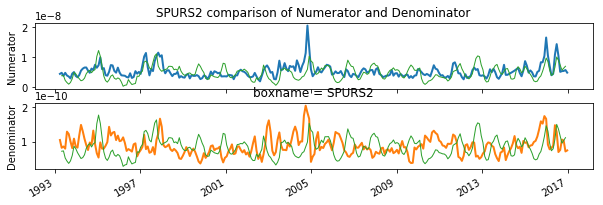

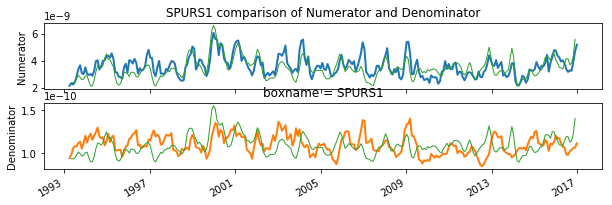

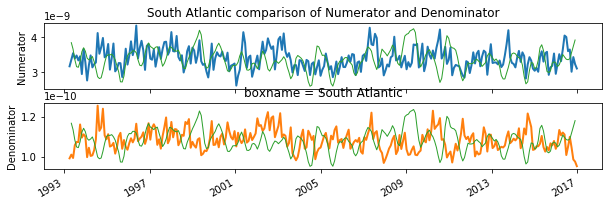

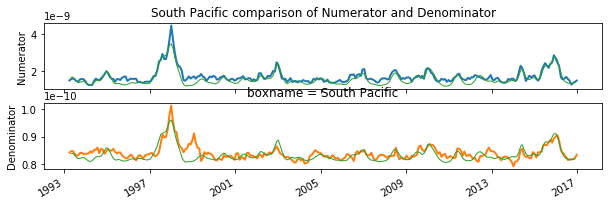

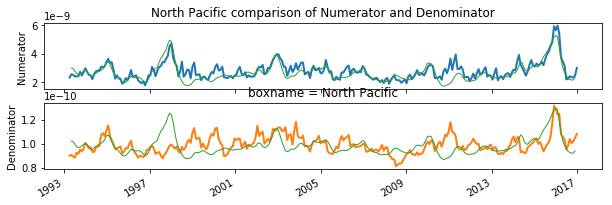

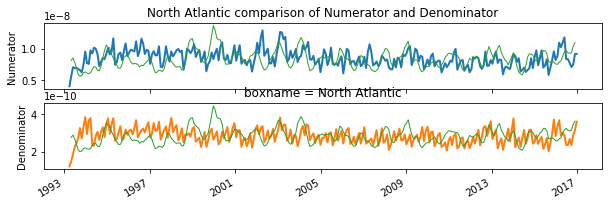

In [6]:
for bb in Numerator_Boxes.boxname.values:
    fig = plt.figure(figsize=np.array([20,6])/2)
    
    y = Numerator_Boxes.sel(boxname=bb)
    y2 = Denominator_Boxes.sel(boxname=bb)
    ref = K_min_Boxes.sel(boxname=bb)
    
    ax = plt.subplot(2,1,1)
    y.plot(color='C0',linewidth=2)
    xarray_norm(ref,y).plot(color='C2',linewidth=1)
    ax.set_ylabel('Numerator')
    plt.title(bb+' comparison of Numerator and Denominator')
    
    ax = plt.subplot(2,1,2)
    y2.plot(color='C1',linewidth=2)
    xarray_norm(ref,y2).plot(color='C2',linewidth=1)
    ax.set_ylabel('Denominator')
    ax.set_xlabel('')

    
#     plt.legend(['Numerator(mean removed)','Denominator','NINO3.4(normalized)'],loc=0)

#     ax.set_xscale('symlog')
#     plt.show()
    fig.savefig(pdir+'/Timeseries_Numerator_Denominator_'+bb+'.pdf')

In [ ]:
# Timeseries plots
pdir = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/PLOTS/Analysis_KOCpaper'
# K_min_Boxes = geom_mean(xut.extractBoxes(
#     xarray_removeSeasonal(Kmin.KOC),Boxes,xdim='lon',ydim ='lat'),['lat','lon'])
K_min_Boxes = harm_mean(xut.extractBoxes(Kmin.KOC,Boxes,xdim='lon',ydim ='lat'),['lat','lon'])
# K_simple_Boxes = harm_mean(xut.extractBoxes(
#     xarray_removeSeasonal(Kmin.K_simple),Boxes,xdim='lon',ydim ='lat'),['lat','lon'])
# Klocker_Boxes = harm_mean(xut.extractBoxes(
#     xarray_removeSeasonal(L_mix),Boxes,xdim='lon',ydim ='lat'),['lat','lon'])
# does the eke need area weighting?
# 
EKE_Boxes = geom_mean(xut.extractBoxes(EKE.eke,Boxes,xdim='lon',ydim ='lat'),['lat','lon'])
# EKE_Boxes = geom_mean(xut.extractBoxes(
#     EKE.eke_noSeasonal,Boxes,xdim='lon',ydim ='lat'),['lat','lon'])
# Box_legend = ['mean KOC','KOC','EKE(normalized + seasonal removed)','ENSO(normalized)']
Box_legend = ['mean KOC','KOC','EKE(normalized)','ENSO(normalized)']
enso_bounds=bounds



In [ ]:
for bb in K_min_Boxes.boxname.values:
    fig = plt.figure(figsize=np.array([20,6])/2)
    ax = plt.axes()
#     y = xut.timefilter(K_min_Boxes.sel(boxname=bb),filterdays,'D',stdev=filterstd)
#     eke = xut.timefilter(EKE_Boxes.sel(boxname=bb),filterdays,'D',stdev=filterstd)
#     enso = xut.timefilter(climate_indicies.NINO34,filterdays,'D',stdev=filterstd)
#     amo = xut.timefilter(climate_indicies.AMO,filterdays,'D',stdev=filterstd)
    
    y = K_min_Boxes.sel(boxname=bb)
#     y_simple = K_simple_Boxes.sel(boxname=bb)*0.25
#     y_klocker = Klocker_Boxes.sel(boxname=bb)
    eke = EKE_Boxes.sel(boxname=bb)
    enso = climate_indicies.NINO34
    amo = climate_indicies.AMO
    
#     y_klocker_norm = xarray_norm(y_klocker,y)
    eke_norm = xarray_norm(eke,y)
    enso_norm = xarray_norm(enso,y)
    amo_norm = xarray_norm(amo,y)
    
    t = y.time.data
    ax.plot(t,np.ones_like(t.astype(float))*y.mean().data,'--k')

    y.plot(color='0.3',linewidth=2)
#     y_simple.plot(color='0.3',linewidth=0.75)
#     y_klocker_norm.plot(color='b',linewidth=0.75)
    eke_norm.plot(ls='--',color='C1',linewidth=1)
    enso_norm.plot(color='C2',linewidth=1)

    ylim = ax.get_ylim()
#     ylim  = [0,3000]
    x = climate_indicies.NINO34.time.data
    y_enso = np.ones_like(climate_indicies.NINO34.time.astype(float))
    y_nina = y_enso.copy()
    y_nino = y_enso.copy()
    y_nino[climate_indicies.NINO34.data<=enso_bounds[1]] = np.nan
    y_nina[climate_indicies.NINO34.data>=enso_bounds[0]] = np.nan
    
    alpha = 0.15
    
    co_nino = '#d6604d'
    co_nina = '#4393c3'
    ax.plot(x,y_nino*ylim[1],color=co_nino,linewidth=10)
    ax.plot(x,y_nina*ylim[1],color=co_nina,linewidth=10)
    ax.plot(x,y_nino*ylim[0],color=co_nino,linewidth=10)
    ax.plot(x,y_nina*ylim[0],color=co_nina,linewidth=10)
    
    plt.title(bb+' all scaled to KOC')
    plt.ylabel('$K_{min}$ $[m^2/s]$')
    
    plt.legend(Box_legend,loc=0)
    # clean up the labels
    ax.set_xlabel('')
    
    # format the ticks
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#     ax.minorticks_on()
    ax.grid(True,which='major',axis='x')
    ax.set_xlim(dt.date(1993,1,1),dt.date(2017,3,1))
    ax.set_ylim(ylim)
    plt.show()
    fig.savefig(pdir+'/Timeseries_'+bb+'.pdf')

In [ ]:
# make a heatmap of EKE vs Kmin
# What is the apparent functional relationship?

plt.figure()
plt.hexbin(EKE.eke.data.flatten(),Kmin.KOC.data.flatten(),xscale='log',yscale='log',norm=mpl.colors.LogNorm())
plt.colorbar()

plt.figure()
plt.hexbin(KOC.Denominator.data.flatten(),KOC.KOC.data.flatten(),xscale='log',yscale='log')
#norm=mpl.colors.LogNorm()
plt.colorbar()
# plt.gca().set_ylim([0,5000])

In [ ]:
#correlate Kmin and K(simple estimate based on klovker)
Kmin.KOC.name = 'Observed'
K.name = 'reconstructed'

cc,pp = xut.corrmap(Kmin.KOC,K,a_x_dim='lon', a_y_dim='lat',b_x_dim='lon', b_y_dim='lat')

In [ ]:
# Produce seasonal plots
pdir = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/PLOTS/Analysis_KOCpaper'

# EKE
fig = plt.figure()
eke_mean = xut.fancymean(EKE.eke,dim=('time'),method=meth,weights=weights)
eke_anom = EKE.eke_seas-eke_mean

eke_anom.attrs = {'units':'m^2/s^2?'}
peke = eke_anom.plot(x='lon',y='lat',col=timespec,col_wrap=3,vmin=-0.005,vmax=0.005,\
                     cmap=plt.cm.RdBu_r,norm=mpl.colors.SymLogNorm(0.001))
peke.fig.savefig(pdir+'/seasonal_eke.png') 

# KOC
koc_mean = xut.fancymean(KOC.KOC_min,dim=('time'),method=meth,weights=weights)
koc_seas = KOC.KOC_min.groupby('time.'+timespec).apply(xut.fancymean,dim=('time'),method=meth,weights=weights)
koc_anom = koc_seas-koc_mean
koc_anom.attrs = {'units':'m^2/s'}
fig = plt.figure()
pkoc = koc_anom.plot(x='i',y='j',col=timespec,col_wrap=3,vmin=-2000,vmax=2000,\
                     cmap=plt.cm.RdBu_r,norm=mpl.colors.SymLogNorm(100,linscale=1.5))
pkoc.fig.savefig(pdir+'/seasonal_koc.png') 

koc_seas_amp = koc_anom.max(dim=timespec)-koc_anom.min(dim=timespec)
koc_seas_amp.name = 'seasonal amplitude of K_min'

seas_boxes_koc = xut.extractBoxes(koc_seas,Seasonal_Boxes,xname='XC',yname ='YC',\
                                xdim='i',ydim='j',method=meth,weights=weights)

seas_boxes_eke = xut.extractBoxes(EKE.eke_seas,Seasonal_Boxes,xdim='lon',ydim='lat',\
                                     method=meth,weights=weights)

# # Reference map only to identify large seasonal cycles...
# fig = plt.figure(figsize=[16,7])
# koc_seas_amp.plot(x='XC',y='YC',robust=True,vmin=0,vmax=2000,norm=mpl.colors.SymLogNorm(100,linscale=1))

# for bb in Seasonal_Boxes.keys():
#     box = Seasonal_Boxes[bb]
#     plt.plot(box[[0,1,1,0,0]],box[[3,3,2,2,3]],color='0',linewidth=1)
#     plt.text(box[0:2].mean(),box[2:4].mean(),bb)
# plt.gca().set_ylim([-65,65])
# plt.gca().set_xlim([0,360])
# plt.show()

# timeseries
fig = plt.figure()
for bb in seas_boxes_koc.boxname.values:
    temp = seas_boxes_koc.sel(boxname=bb)-seas_boxes_koc.sel(boxname=bb).mean(dim=timespec)
    # shift southern hemi values by 6
    if Seasonal_Boxes[bb][2]<0:
        temp.plot(linestyle='--')
    else:
        temp.plot()
plt.title('Selected seasonal anomalies of K_min')
art = []
lgd = plt.legend(seas_boxes_koc.boxname.values,ncol=3,loc=9, bbox_to_anchor=(0.5, -0.1))
art.append(lgd)
plt.savefig(pdir+'/KOC_anomaly_seasonal_timeseries.pdf', additional_artists=art,bbox_inches='tight')

# Control figure...dont show
fig = plt.figure()
for bb in seas_boxes_eke.boxname.values:
    temp = seas_boxes_eke.sel(boxname=bb)-seas_boxes_eke.sel(boxname=bb).mean(dim=timespec)
    if Seasonal_Boxes[bb][2]<0:
        temp.plot(linestyle='--')
    else:
        temp.plot()
plt.title('Selected seasonal anomalies of EKE')
art = []
lgd = plt.legend(seas_boxes_koc.boxname.values,ncol=3,loc=9, bbox_to_anchor=(0.5, -0.1))
art.append(lgd)
plt.savefig(pdir+'/EKE_anomaly_seasonal_timeseries.pdf', additional_artists=art,bbox_inches='tight')


In [ ]:
Kmin['KOC']

In [ ]:
# QC regarding the accuracy of the results when the coarse graining is adjusted
odir = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/Analysis_KOCpaper/QC_Coarsening'

# # This part is hella slow and should stay deactivated
# resolutions = [5,10]
# ddir = '/Users/juliusbusecke/Desktop/TimeMachineExcluded/run_KOC_PSI'
# init_path = ddir+'/'+'SSS_tracer.bin'
# vpath = '/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/AVISO_validmask/validmask.bin'
# eng = main.TracerEngine(ddir,init_path,63,validmaskpath=vpath)
# results = dict([])
# boxes = []
# iters = range(2688,20000,2688)
# iters = 'all'
# for rr in resolutions:
#     a,_ = eng.KOC_combined(iters=iters,interval=rr,debug=True)
#     a.to_netcdf(odir+'/'+'KOC_PSI_'+str(rr)+'deg')
        
resolutions = [2,3,5]
fnames = [odir+'/QC_'+str(a)+'deg/KOC_PTRACER_FINAL.nc' for a in resolutions]
ds = [xr.open_dataset(f) for f in fnames]
boxes = [xut.extractBoxes(a.KOC,Boxes,xname='XC',yname='YC',method='geometric',weights='area') for a in ds]
boxes_combo = xr.concat(boxes,'resolution')
boxes_combo['resolution'] = resolutions

for bn in boxes_combo.boxname.data:
    plt.figure()
    for rr in boxes_combo.resolution.data:
        boxes_combo.sel(boxname=bn,resolution=rr).plot()
    boxes_combo.sel(boxname=bn).std(dim='resolution').plot()
    plt.title(bn)
    plt.legend(resolutions)
    plt.show()

In [ ]:
# Backup configs for future projects
# Global Parameters
Boxes = {'South Pacific':np.array([210,280,-45,-15]),
         'North Pacific':np.array([170,225,15,45]),
#          'Southwest Indian':np.array([40,75,-35,-10]),
#          'Southeast Indian':np.array([75,110,-35,-10]),
         'South Atlantic':np.array([310,359,-45,-15]),
#          'Agulhas':np.array([24,32,-39,-31]),
#          'Agulhas_Beal':np.array([26,30,-37,-33]),
#          'Gulf Stream':np.array([295,320,32,38]),
#          'Kuroshio':np.array([143,168,30,35]),
         'SPURS':np.array([315,330,15,30]),
         'SPURS2':np.array([230,240,5,15]),
#          'Test':np.array([60,120,-25,-15]),
#          'North Atlantic':np.array([300,340,15,30])}
          'North Atlantic':np.array([300,340,15,45])}


In [ ]:


# # Test case
# x = harm_mean(KOC.KOC.isel(initial_condition=0),'tracernum')
# # .sel(time=slice('2000','2009'))
# test = xut.timefilter(x,180,'D',stdev=0.15)
# test2 = x.rolling(time=3,center=True).reduce(harm_mean)

# x.sel(lon=240,lat=-35,method='nearest').plot()
# test.sel(lon=240,lat=-35,method='nearest').plot()
# test2.sel(lon=240,lat=-35,method='nearest').plot()

In [ ]:
#What is going on with those outliers?
# sub_ds = harm_mean(KOC.isel(initial_condition=0).sel(lon=slice(150,230),lat=slice(-40,0)),'tracernum')

lon_s = slice(180,190)
lat_s = slice(15,30)
sub_ds = harm_mean(KOC.isel(initial_condition=0).sel(lon=lon_s,lat=lat_s),'tracernum')
sub_ds_min = Kmin.sel(lon=lon_s,lat=lat_s)


plt.figure()
harm_mean(sub_ds_min['KOC'],'time').plot(x='lon',y='lat',robust=True)
plt.figure()
harm_mean(sub_ds['KOC'],'time').plot(x='lon',y='lat',robust=True)
plt.figure()
harm_mean(sub_ds['Denominator'],'time').plot(x='lon',y='lat',robust=True)
plt.figure()
harm_mean(sub_ds['Numerator'],'time').plot(x='lon',y='lat',robust=True)
plt.figure()
# sub_ds['mask_count'].plot(x='lon',y='lat',robust=True)
sub_ds.gradient_criterion.mean('time').plot(x='lon',y='lat',robust=True)

ts_bad = sub_ds.sel(lon=185.0,lat=25.0,method='nearest').sel(time=slice('1993','1996'))
ts_good = sub_ds.sel(lon=184.0,lat=25.0,method='nearest').sel(time=slice('1993','1996'))
for vv in ['KOC']:
    plt.figure()
    ts_bad[vv].plot(color='r')
    ts_good[vv].plot(color='C1')
    plt.gca().set_yscale('log')

In [ ]:
# Plot mixing length
Kmin['MixingLength'].mean(['time']).plot(x='lon',y='lat',robust=True)

KOC.gradient_criterion.mean('time').plot(x='lon',y='lat',col='tracernum',row='initial_condition',robust=True)

In [ ]:
# Try out the Klocker and Abernathey 2014 formula
mix_eff = 0.35
L = 75000.0 
k = 2*np.pi/L 
gamma = 1/(4*24*60*60.0) #best fit from Klocker and abernathey 2014
c = -0.025 # an average value

# I need a mean flow field (pretty hacky but should work for now)
from xarrayutils import aggregate
mean_aviso = xr.open_dataset('/Users/juliusbusecke/Work/PROJECTS/COLL_RYAN/OUTPUT/AVISO_mean/time_mean.nc',chunks={'time':1})
mean_aviso = mean_aviso.sel(lat=slice(-80,80))
mean_u = xr.DataArray(aggregate(mean_aviso.u,[('lon',4),('lat',4)]).mean('time').data,
                      dims=VEL.u.mean('time').dims,
                      coords=VEL.u.mean('time').coords)
mean_v = xr.DataArray(aggregate(mean_aviso.v,[('lon',4),('lat',4)]).mean('time').data,
                      dims=VEL.v.mean('time').dims,
                      coords=VEL.v.mean('time').coords)
u = VEL.v+mean_v
u_rms = xr.ufuncs.sqrt(2*EKE.eke)

#phase speed of eddies = zonal vel? (SHoul be depth integrated but I dont have that yet)
# mean_v

factor = 1+(k**2/gamma**2*(c-u)**2)

L_mix = L/factor
K = mix_eff*u_rms*L_mix

In [ ]:
# Show difference between averaging procedures
plt.figure(figsize=[16,12])
ax = plt.subplot(2,2,1)
harm_mean(Kmin.KOC,'time').plot(ax=ax,**koc_style)
plt.title('Kmin log average in time')

ax = plt.subplot(2,2,2)
Kmin.KOC.mean('time').plot(ax=ax,**koc_style)
plt.title('Kmin arithmetic average in time')

ax = plt.subplot(2,2,3)
(Kmin.KOC.mean('time')-harm_mean(Kmin.KOC,'time')).plot(ax=ax,**koc_an_style)
plt.title('Difference between log mean and arithmetic mean')

ax = plt.subplot(2,2,4)
KOC_AB13 = xr.open_dataset('/Users/juliusbusecke/Work/DATA_OLD/Abernathey_OC_Diff/OUTPUT/diffusivity_AM2013.nc')
# diff = xr.DataArray(harm_mean(Kmin.KOC.mean('time').data-KOC_AB13.KMIN.data,
#                     dims= Kmin.KOC.mean('time').dims,coords=Kmin.KOC.mean('time').coords)
# diff.plot(ax=ax,**koc_an_style)
KOC_AB13.KMIN.plot(ax=ax,**koc_style)
plt.title('Abernathey et al 2013')

In [ ]:
# Calculate 'simple' K by multiplying u_rms*l_mix
Kmin['K_simple'] = xr.ufuncs.sqrt(2*EKE.eke)*Kmin.MixingLength*1000
harm_mean(Kmin['K_simple'],'time').plot(robust=True)

ratio = harm_mean(Kmin.KOC,'time')/harm_mean(Kmin.K_simple,'time')
ratio.name = 'Ratio between KOC and K_simple'

plt.figure()
ratio.plot(robust=True)

plt.figure()
ratio.plot.hist(bins=np.arange(0,1,0.01))